In [1]:
import os

import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic

from pyia import GaiaData
import theano
# theano.config.gcc.cxxflags = "-fbracket-depth=16000" # default is 256
import pymc3 as pm
import theano.tensor as tt
import exoplanet as xo

pm.__version__

'3.9.2'

Expected mean disk velocity in ICRS:

In [2]:
xtmp = coord.CartesianRepresentation(100, 0, 0, unit=u.km)
vlsr = coord.CartesianDifferential(-(np.array([12.9, 245.6, 7.78]) - np.array([0, 234, 0])) * u.km/u.s)
vthin = coord.SkyCoord(xtmp.with_differentials(vlsr), frame='galactic').icrs.velocity.d_xyz.value

xtmp = coord.CartesianRepresentation(100, 0, 0, unit=u.km)
vlsr = coord.CartesianDifferential(-(np.array([12.9, 245.6, 7.78]) - np.array([0, 200, 0])) * u.km/u.s)
vthik = coord.SkyCoord(xtmp.with_differentials(vlsr), frame='galactic').icrs.velocity.d_xyz.value

xtmp = coord.CartesianRepresentation(100, 0, 0, unit=u.km)
vsun = coord.CartesianDifferential(-np.array([12.9, 245.6, 7.78]) * u.km/u.s)
vhalo = coord.SkyCoord(xtmp.with_differentials(vsun), frame='galactic').icrs.velocity.d_xyz.value

vthin, vthik, vhalo

(array([ 1.72666906, 17.96839664, -5.97107496]),
 array([-15.0730518 ,  33.09260716, -31.36846921]),
 array([-113.89493924,  122.05855141, -180.76490601]))

In [3]:
pc_mas_yr_per_km_s = (1 * u.km/u.s).to(u.pc*u.mas/u.yr, u.dimensionless_angles()).value
km_s_per_pc_mas_yr = 1 / pc_mas_yr_per_km_s

In [4]:
g = GaiaData(os.path.expanduser('~/data/GaiaDR2/rv-good-plx.fits'))

In [5]:
the_og = g[g.source_id == 1490845584382687232]
v0 = the_og.get_skycoord().velocity.d_xyz.value.T[0]
sigma_0 = 0.6  # km/s
v0

array([-6.93189151, 24.30123728, -9.50923957])

How much could the group have dispersed in free space?

In [6]:
(100*u.Myr * 0.6*u.km/u.s).to(u.pc)

<Quantity 61.3627299 pc>

In [7]:
def get_tangent_basis(ra, dec):
    """
    row vectors are the tangent-space basis at (alpha, delta, r)
    ra, dec in radians
    """
    M = np.array([
        [-np.sin(ra), np.cos(ra), 0.],
        [-np.sin(dec)*np.cos(ra), -np.sin(dec)*np.sin(ra), np.cos(dec)],
        [np.cos(dec)*np.cos(ra), np.cos(dec)*np.sin(ra), np.sin(dec)]
    ])
    return M

In [8]:
class UniformSpaceDensity(pm.Continuous):

    def __init__(self, rlim, **kwargs):
        """A uniform space density prior over a distance, r, between (0, rlim)
        """

        self.rlim = float(rlim)
        assert (self.rlim > 0)
        self._fac = np.log(3.) - 3 * np.log(self.rlim)

        shape = kwargs.get("shape", None)
        if shape is None:
            testval = 0.5 * self.rlim
        else:
            testval = 0.5 * self.rlim + np.zeros(shape)
        kwargs["testval"] = kwargs.pop("testval", testval)
        super(UniformSpaceDensity, self).__init__(**kwargs)

    def _random(self, size=None):
        uu = np.random.uniform(size=size)
        return np.cbrt(uu) * self.rlim

    def random(self, point=None, size=None):
        return generate_samples(
            self._random,
            dist_shape=self.shape,
            broadcast_shape=self.shape,
            size=size,
        )

    def logp(self, value):
        return 2 * tt.log(tt.as_tensor_variable(value)) + self._fac

In [9]:
c = g.get_skycoord()
the_og_c = the_og.get_skycoord()[0]

sep3d_mask = c.separation_3d(the_og_c) < 50*u.pc
vel3d_mask = (c.velocity - the_og_c.velocity).norm() < 15*u.km/u.s
xv_mask = vel3d_mask & sep3d_mask

subg = g[xv_mask][:100]

sep3d_mask.sum(), vel3d_mask.sum(), xv_mask.sum()

(10348, 302969, 1079)

In [10]:
Cs = subg.get_cov(units=dict(pmra=u.mas/u.yr, pmdec=u.mas/u.yr, radial_velocity=u.km/u.s))
C = Cs[:, 2:, 2:]

In [11]:
N = len(subg)

ra = subg.ra.to_value(u.rad)
dec = subg.dec.to_value(u.rad)
M = np.stack([get_tangent_basis(ra[i], dec[i]) for i in range(N)])
y = np.stack([subg.parallax.value, 
              subg.pmra.value, 
              subg.pmdec.value, 
              subg.radial_velocity.value], 
             axis=1)

Cinvs = np.stack([np.linalg.inv(C[n]) for n in range(N)], axis=0)

C.shape, M.shape, y.shape

((100, 4, 4), (100, 3, 3), (100, 4))

16.275168764033282 -1.4699375841411744
33.68416405247106 18.24113813937882
19.989999306596545 -10.257146472267168


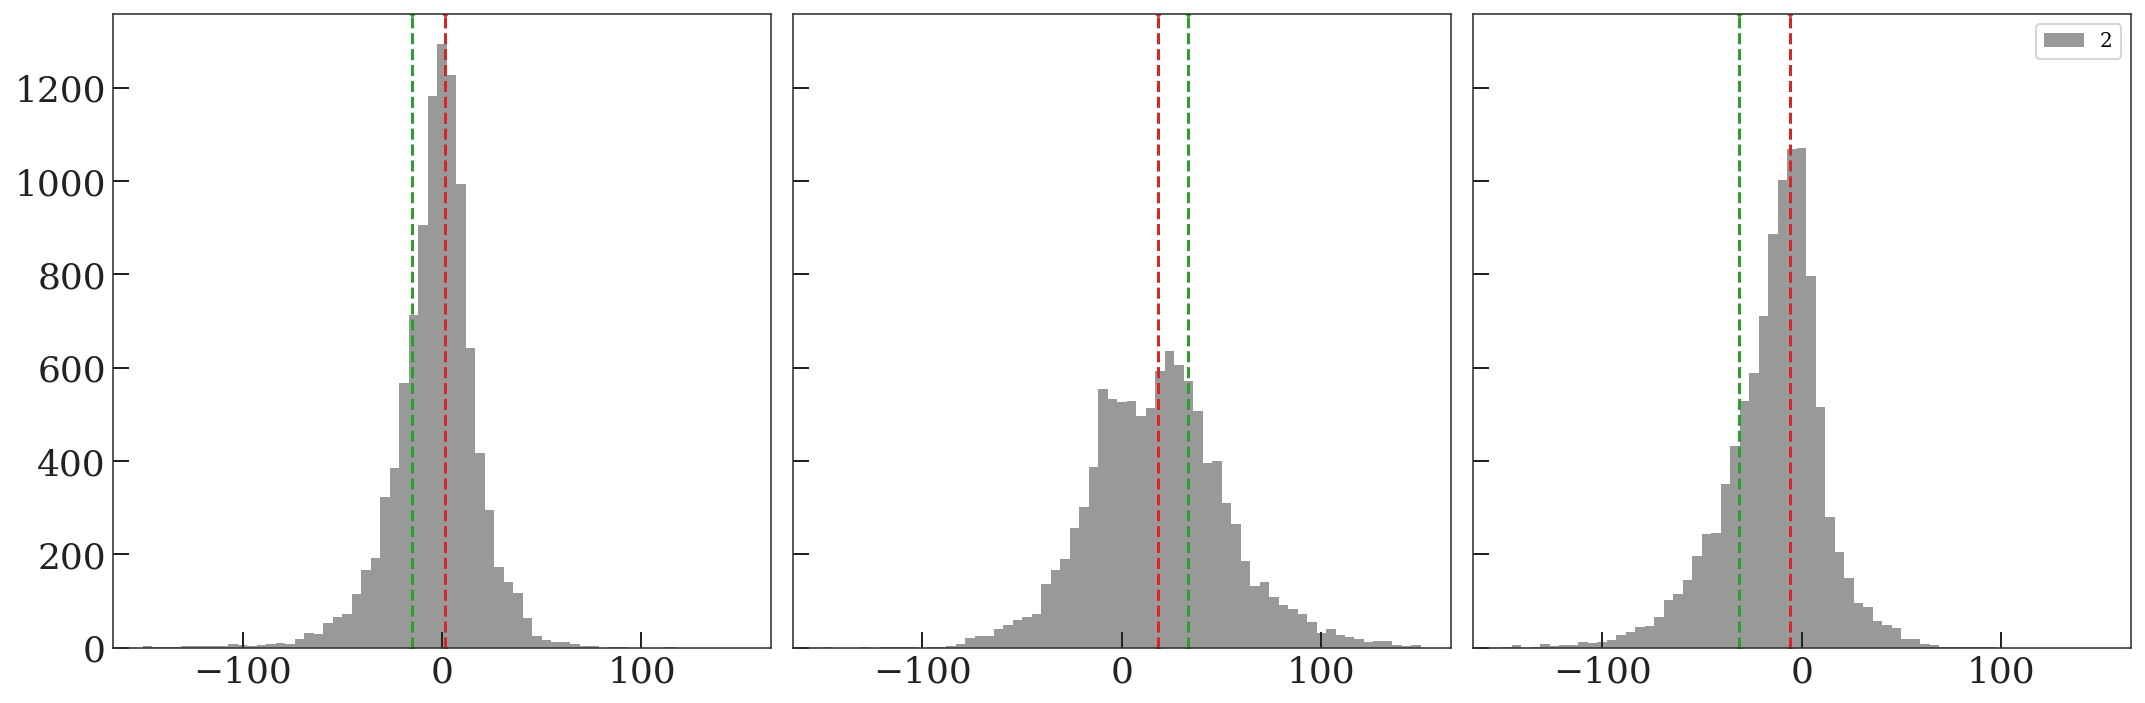

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
for i in range(3):
    ax = axes[i]
    
    _x = g[sep3d_mask].get_skycoord().velocity.d_xyz.value[i]
    print(1.5 * np.median(np.abs(_x - np.median(_x))),
          np.median(_x))
    ax.hist(g[sep3d_mask].get_skycoord().velocity.d_xyz.value[i],
            bins=np.linspace(-150, 150, 64), alpha=0.4, label=str(i));
    
    ax.axvline(vthin[i], color='tab:red', linestyle='--')
    ax.axvline(vthik[i], color='tab:green', linestyle='--')
    
ax.legend(loc='best')

fig.tight_layout()

In [13]:
test_vxyz = subg.get_skycoord().velocity.d_xyz.value.T
test_d = subg.distance.value

In [14]:
sigma_thin = 20.  # np.array([15, 35, 20.])
sigma_thik = 50.
sigma_halo = 125.  # np.full(3, 125.)  # km/s

# Number of prior mixture components:
K = 4
with pm.Model() as model:
    # r = pm.Uniform("r", 1, 500, shape=N, testval=test_d)
    r = UniformSpaceDensity("r", 2000, shape=N, testval=test_d)
    
    # Mixture model for 3D velocity
    w = pm.Dirichlet('w', a=np.ones(K))
    
    _v0 = pm.Normal.dist(v0, np.full(3, sigma_0), 
                         shape=(N, 3))
    _v1 = pm.Normal.dist(vthin, sigma_thin, 
                         shape=(N, 3))
    _v2 = pm.Normal.dist(vthik, sigma_thik, 
                         shape=(N, 3))
    _v3 = pm.Normal.dist(vhalo, sigma_halo, 
                         shape=(N, 3))
    vxyz = pm.Mixture('vxyz', w=w, comp_dists=[_v0, _v1, _v2, _v3], 
                      testval=test_vxyz, shape=(N, 3)) 
    
    v0_logp = pm.Deterministic('v0_logp', _v0.logp(vxyz))
    v1_logp = pm.Deterministic('v1_logp', _v1.logp(vxyz))
    v2_logp = pm.Deterministic('v2_logp', _v2.logp(vxyz))
    v3_logp = pm.Deterministic('v3_logp', _v3.logp(vxyz))
    
    # Velocity in tangent plane coordinates
    vtan = tt.batched_dot(M, vxyz)
    
    model_pm = vtan[:, :2] / r[:, None] * pc_mas_yr_per_km_s
    model_rv = vtan[:, 2:3]
    model_y = tt.concatenate((1000 / r[:, None], model_pm, model_rv), axis=1)
    
    # for n in range(N):
    #     pm.MvNormal(f'y{n}', mu=model_y[n], cov=C[n], observed=y[n], shape=4)
    val = tt.as_tensor_variable(0.)
    for n in range(N):
        # val += pm.MvNormal.dist.logp(mu=model_y[n], cov=C[n], observed=y[n], shape=4)
        dy = model_y[n] - y[n]
        val += -0.5 * tt.transpose(dy).dot(Cinvs[n]).dot(dy)
    pm.Potential("more_logp", val)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


In [ ]:
with model:
    res = xo.optimize()

In [ ]:
res['r'] / test_d

In [16]:
logps = np.zeros((N, K))
for k in range(K):
    logps[:, k] = res[f'v{k}_logp'].sum(axis=1)

In [17]:
from scipy.special import logsumexp

In [18]:
# for i in range(3):
#     _x = test_vxyz[:, i]
#     print(1.5 * np.median(np.abs(_x - np.median(_x))),
#           np.median(_x))
#     plt.hist(test_vxyz[:, i],
#              bins=np.linspace(-100, 100, 64), alpha=0.4, label=str(i),
#              density=True);
    
#     _grid = np.linspace(-100, 100, 1000)
#     plt.plot(_grid, norm.pdf(_grid, vdisk[i], sigma_disk[i]), marker='')
    
# plt.legend(loc='best')

In [19]:
prob = np.exp(logps[:, 0] - logsumexp(logps, axis=1))

(array([9., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.00000000e+00, 2.53179742e-07, 5.06359483e-07, 7.59539225e-07,
        1.01271897e-06, 1.26589871e-06, 1.51907845e-06, 1.77225819e-06,
        2.02543793e-06, 2.27861767e-06, 2.53179742e-06]),
 <a list of 10 Patch objects>)

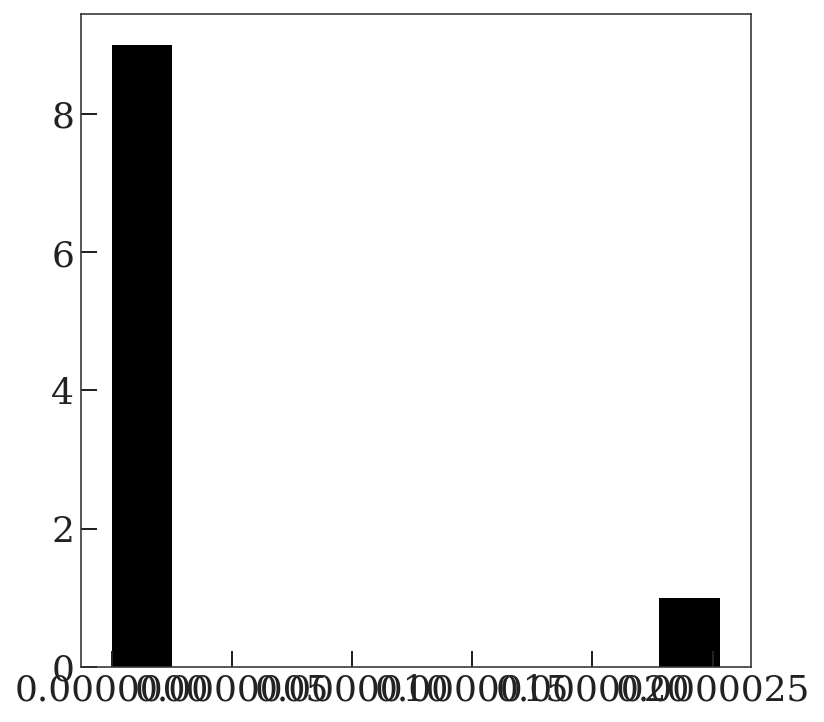

In [20]:
plt.hist(prob)

In [19]:
subg[prob > 0.5].source_id

1320894312595678976
1397457048152981632
1476485996883837184
1396617472242087168
1490845584382687232
1523644978312478976
1263985102569989504
1549259098113618688
1523645047031954944
4026742744369123584
1189404610382948224


In [26]:
highprob = subg[prob > 0.5]

mg = highprob.phot_g_mean_mag - highprob.distmod
bprp = highprob.phot_bp_mean_mag - highprob.phot_rp_mean_mag

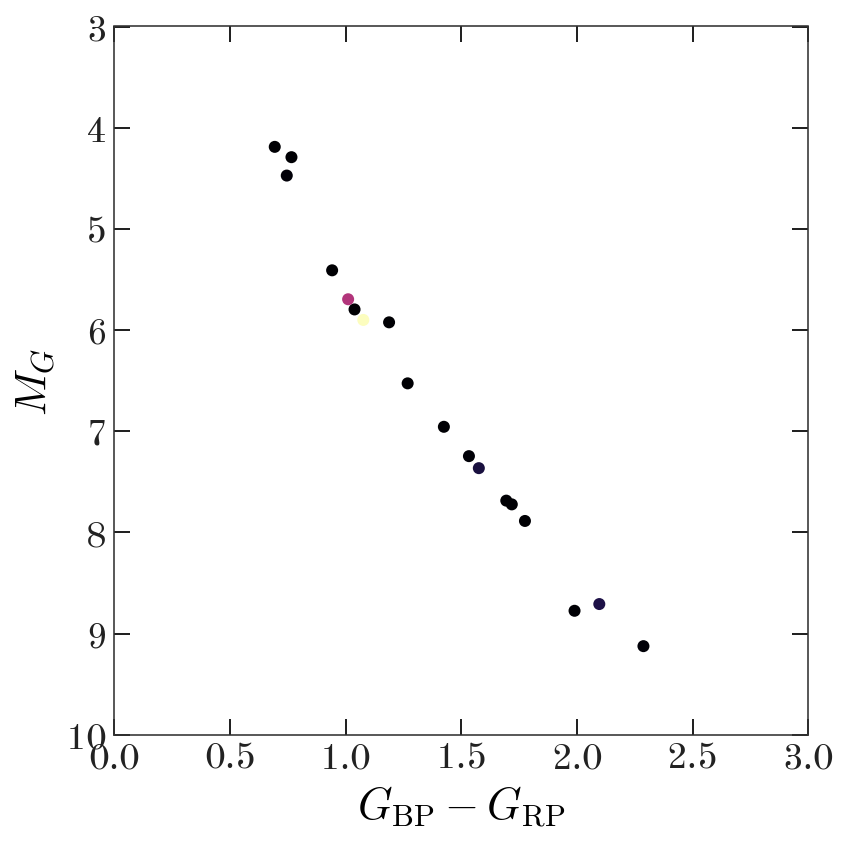

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.scatter(bprp, mg, c=prob[prob > 0.5], 
           cmap='magma_r')

ax.set_xlim(0, 3)
ax.set_ylim(10, 3)

ax.set_xlabel(r'$G_{\rm BP}-G_{\rm RP}$')
ax.set_ylabel('$M_G$')

fig.set_facecolor('w')
fig.tight_layout()

(-90.0, 90.0)

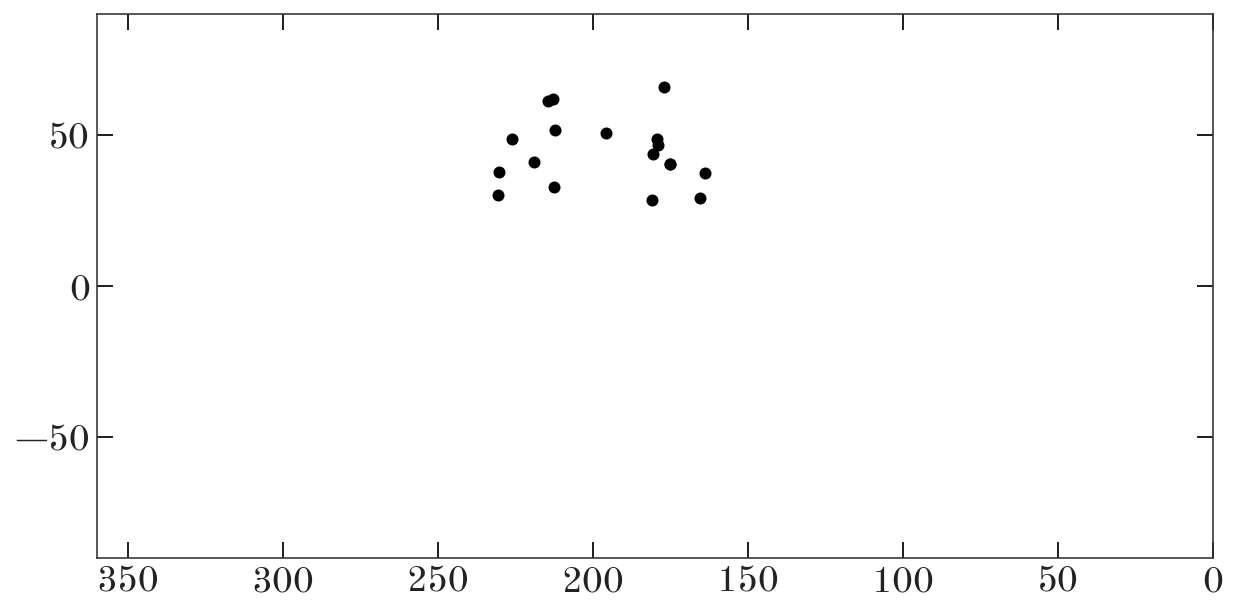

In [37]:
highprob_c = highprob.get_skycoord()

plt.figure(figsize=(10, 5))
plt.scatter(highprob_c.barycentricmeanecliptic.lon.degree,
            highprob_c.barycentricmeanecliptic.lat.degree)
plt.xlim(360, 0)
plt.ylim(-90, 90)

In [51]:
highprob_tbl = highprob.data
highprob_tbl['prob'] = prob[prob > 0.5]
highprob_tbl.write('/Users/apricewhelan/Downloads/TheOGGroup.csv', format='ascii.ecsv')